In [90]:
import numpy as np
import numba as nb
from numba import jit, njit
import matplotlib.pyplot as plt

Recall the variational wavefunction is
$$
\chi_0(\xi) = \left[\sqrt{\frac{3}{2}} \frac{\widetilde{N}^2}{\widetilde{N}^2 + 1}\right]^{1/2} e^{-\xi^2}
$$

In [168]:
@njit
def init_chi(Nt, xi):
    return np.sqrt(np.sqrt(3/2)*(Nt**2)/(Nt**2+1)) * np.exp(-xi**2)

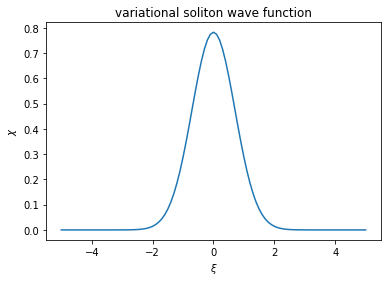

In [181]:
# declare parameters
xi_min, xi_max = -5, 5
n_points = 101
delta = (xi_max - xi_min)/(n_points - 1)
Nt = 1

# set things up
xi = np.linspace(xi_min, xi_max, n_points)
chi0 = init_chi(Nt, xi)
plt.plot(xi, chi0)
plt.xlabel(r"$\xi$")
plt.ylabel(r"$\chi$")
plt.title("variational soliton wave function")
plt.show()

The potential is given by $V(\chi) = \beta^2((|\chi|^2-1)^2-1)$

In [182]:
@njit
def potential(chi, Nt):
    beta = (Nt**2 + 1)/((3**0.25)*Nt)
    return (beta**2)*(((chi**2) - 1)**2 - 1)

The initial expectation values are given by
$$
\begin{align*}
\langle \chi | \chi \rangle &= \delta \sum_i \chi_i^2 \\
\bar{V} = \langle \chi | V | \chi \rangle &= \delta \sum_i V_i \chi_i^2 \\
\bar{K} = \langle \chi | K | \chi \rangle &= -\delta^{-1} \sum_i (\chi_i \bar{\chi}_{nn} - \chi_i^2)
\end{align*}
$$

In [183]:
@njit
def chi_nn(chi):
    # average each point over nearest neighbors
    # assume values outside range are 0
    _chi = np.zeros_like(chi)
    _chi[1:len(chi)-1] = (chi[0:len(chi)-2] + chi[2:len(chi)])/2
    _chi[0] = chi[1]/2
    _chi[-1] = chi[-1]/2
    return _chi
chi_nn(chi0);

In [184]:
norm = delta * np.sum(chi0**2)
Vbar = delta * np.dot(potential(chi0, Nt), (chi0**2))
Kbar = -np.sum(chi0*chi_nn(chi0) - chi0**2)/delta
(norm, Vbar, Kbar, (Kbar + Vbar)/norm)

(0.7674950309598665,
 -1.1512425464397997,
 0.38278974364252677,
 -1.0012479192682313)

The _change_ in expectation values are given by
$$
\begin{align*}
\Delta \langle \chi | \chi \rangle &= (\chi_{0,\text{new}}^2 - \chi_{0,\text{old}}^2) \delta \\
\Delta \langle \chi | V | \chi \rangle &= V_0 (\chi_{0,\text{new}}^2 - \chi_{0,\text{old}}^2) \delta \\
\Delta \langle \chi | K | \chi \rangle &= -2\delta^{-1}(\chi_{0,\text{new}} - \chi_{0,\text{old}}) \bar{\chi}_{nn} + \delta^{-1}(\chi_{0,\text{new}}^2 - \chi_{0,\text{old}}^2)
\end{align*}
$$

In [185]:
@njit
def update(chi, Nt, delta):
    E_arr = np.zeros(1000)
    for i in range(1000):
        # common quantities that will be reused
        _chi_nn = chi_nn(chi)
        chi2 = chi**2
        V0 = potential(chi, Nt)
        # update expectation values
        norm = delta * np.sum(chi2)
        Vbar = delta * np.dot(V0, chi2)
        Kbar = -np.sum(chi*_chi_nn - chi2)/delta
        E = (Kbar + Vbar)/norm
        # update field values
        chi = _chi_nn / (1 - (E - V0)*(delta**2))
        E_arr[i] = E
    return E_arr, chi

In [186]:
E_arr, chif = update(chi0, Nt, delta)

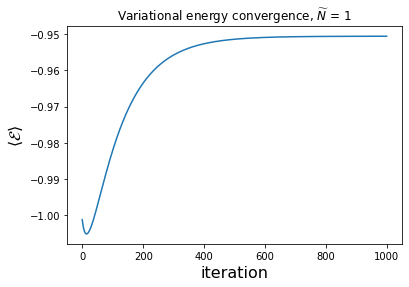

In [187]:
plt.plot(E_arr)
plt.xlabel("iteration", fontsize=16)
plt.ylabel(r"$\langle\mathcal{E}\rangle$", fontsize=16)
plt.title(r"Variational energy convergence, $\widetilde{N}$ = " + str(Nt))
plt.savefig("images/energy_convergence.png", bbox_inches="tight", dpi=100, facecolor="w", transparent=False)

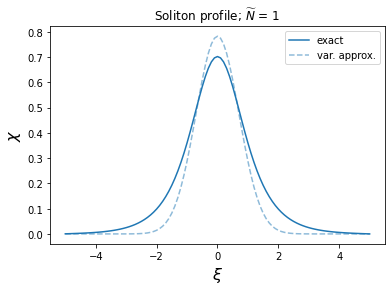

In [177]:
plt.plot(xi, chif, label="exact")
plt.plot(xi, chi0, color="C0", alpha=0.5, linestyle="--", label="var. approx.")
plt.xlabel(r"$\xi$", fontsize=16)
plt.ylabel(r"$\chi$", fontsize=16)
plt.title(r"Soliton profile; $\widetilde{N}$"f" = {Nt}")
plt.legend()
plt.savefig(f"images/numerical_soliton_profile_comparison.png", bbox_inches="tight", dpi=100, facecolor="w", transparent=False)
plt.show()

In [134]:
@njit
def chi_solve(Nt, n_points=101, n_iter=1000, xi_min=-5, xi_max=+5, eps=1e-9):
    delta = (xi_max - xi_min)/(n_points - 1)
    xi = np.linspace(xi_min, xi_max, n_points)
    chi0 = init_chi(Nt, xi)
    chi = chi0
    E_arr = np.zeros(n_iter)
    for i in range(n_iter):
        # common quantities that will be reused
        _chi_nn = chi_nn(chi)
        chi2 = chi**2
        V0 = potential(chi, Nt)
        # update expectation values
        norm = delta * np.sum(chi2)
        Vbar = delta * np.dot(V0, chi2)
        Kbar = -np.sum(chi*_chi_nn - chi2)/delta
        E = (Kbar + Vbar)/norm
        # update field values
        chi = _chi_nn / (1 - (E - V0)*(delta**2)+eps)
        E_arr[i] = E
    return E_arr, xi, chi0, chi

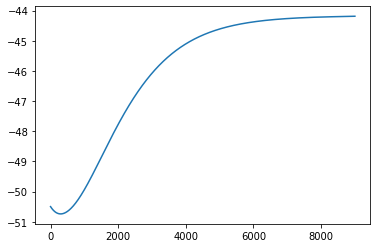

In [214]:
E_arr, xi, chi0, chi = chi_solve(Nt=10, n_iter=int(9e3), n_points=2000)
plt.plot(E_arr)

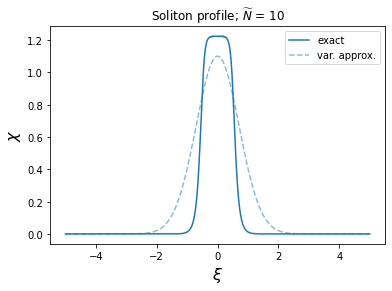

In [217]:
plt.plot(xi, chi, label="exact")
plt.plot(xi, chi0, color="C0", alpha=0.5, linestyle="--", label="var. approx.")
plt.xlabel(r"$\xi$", fontsize=16)
plt.ylabel(r"$\chi$", fontsize=16)
plt.title(r"Soliton profile; $\widetilde{N}$"f" = {10}")
plt.legend()
plt.savefig(f"images/soliton_profile_Nt=10.png", bbox_inches="tight", dpi=100, facecolor="w", transparent=False)
plt.show()

We can get excited states by using initial wave functions with nodes.